# Filtering outlier cells
This tutorial discusses how to remove outlier cells in morphological datasets. To avoid these cells obfuscating downstream analysis, we will build a classifier to detect and remove them. There are three parts to this tutorial:

1. Introduction to the dataset.
2. Exploratory analysis
3. Getting a statistical understanding of the features that might delineate poorly segmented cells from correctly measured cells.
4. Building and validating a classifier to remove outlier cells.

Overall, this tutorial is written as a protocol to how we overcame outlier cells in our datasets. Since the exact analysis will differ per experimental setup details will vary. However, we hope that the ideas presented herein prove helpful for researchers with similar problems in their analyses.

**Note**: unfortunately at time of writing the dataset discussed below has not been published and can therefore not be distributed as part of scmorph.

## Introduction to the dataset
This dataset is from a differentiating cell line that was assayed over 19 time points. We expect to find multiple cell populations (e.g. differentiated and undifferentiated cells) in the same well, so performing aggregation is inadvisable. Instead, we are interested in understanding the present cell states. However, we observed during initial analysis with CellProfiler that ~10% of cells are poorly segmented. These cells will likely be mis-classified as a distinct cell state and could impede downstream analysis, so we would like to remove them first.
Specifically, we we will look at 19,000 cells derived from 19 plates/time points (1,000 cells per plate). 

## Exploratory analysis
First, we will perform basic exploratory analysis to visualise the poorly segmented cells.

In [30]:
import scmorph as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from statsmodels.stats.multitest import fdrcorrection

plt.rcParams["figure.dpi"] = 200
%cd ~/projects/scmorph
input_file = "./results/bhughes/pseudo_sc_sample.csv"

%pip install --quiet imblearn sklearn

/Users/s2221912/projects/scmorph
Note: you may need to restart the kernel to use updated packages.


FilteredNuclei_AreaShape_BoundingBoxArea
FilteredNuclei_AreaShape_CentralMoment_0_0
FilteredNuclei_AreaShape_CentralMoment_0_1
FilteredNuclei_AreaShape_CentralMoment_0_2
FilteredNuclei_AreaShape_CentralMoment_0_3
FilteredNuclei_AreaShape_CentralMoment_1_0
FilteredNuclei_AreaShape_CentralMoment_1_1
FilteredNuclei_AreaShape_CentralMoment_1_2
FilteredNuclei_AreaShape_CentralMoment_1_3
FilteredNuclei_AreaShape_CentralMoment_2_0
FilteredNuclei_AreaShape_CentralMoment_2_1
FilteredNuclei_AreaShape_CentralMoment_2_2
FilteredNuclei_AreaShape_CentralMoment_2_3
FilteredNuclei_AreaShape_Extent
FilteredNuclei_AreaShape_NormalizedMoment_0_2
FilteredNuclei_AreaShape_NormalizedMoment_0_3
FilteredNuclei_AreaShape_NormalizedMoment_1_1
FilteredNuclei_AreaShape_NormalizedMoment_1_2
FilteredNuclei_AreaShape_NormalizedMoment_1_3
FilteredNuclei_AreaShape_NormalizedMoment_2_0
FilteredNuclei_AreaShape_NormalizedMoment_2_1
FilteredNuclei_AreaShape_NormalizedMoment_2_2
FilteredNuclei_AreaShape_NormalizedMoment_2

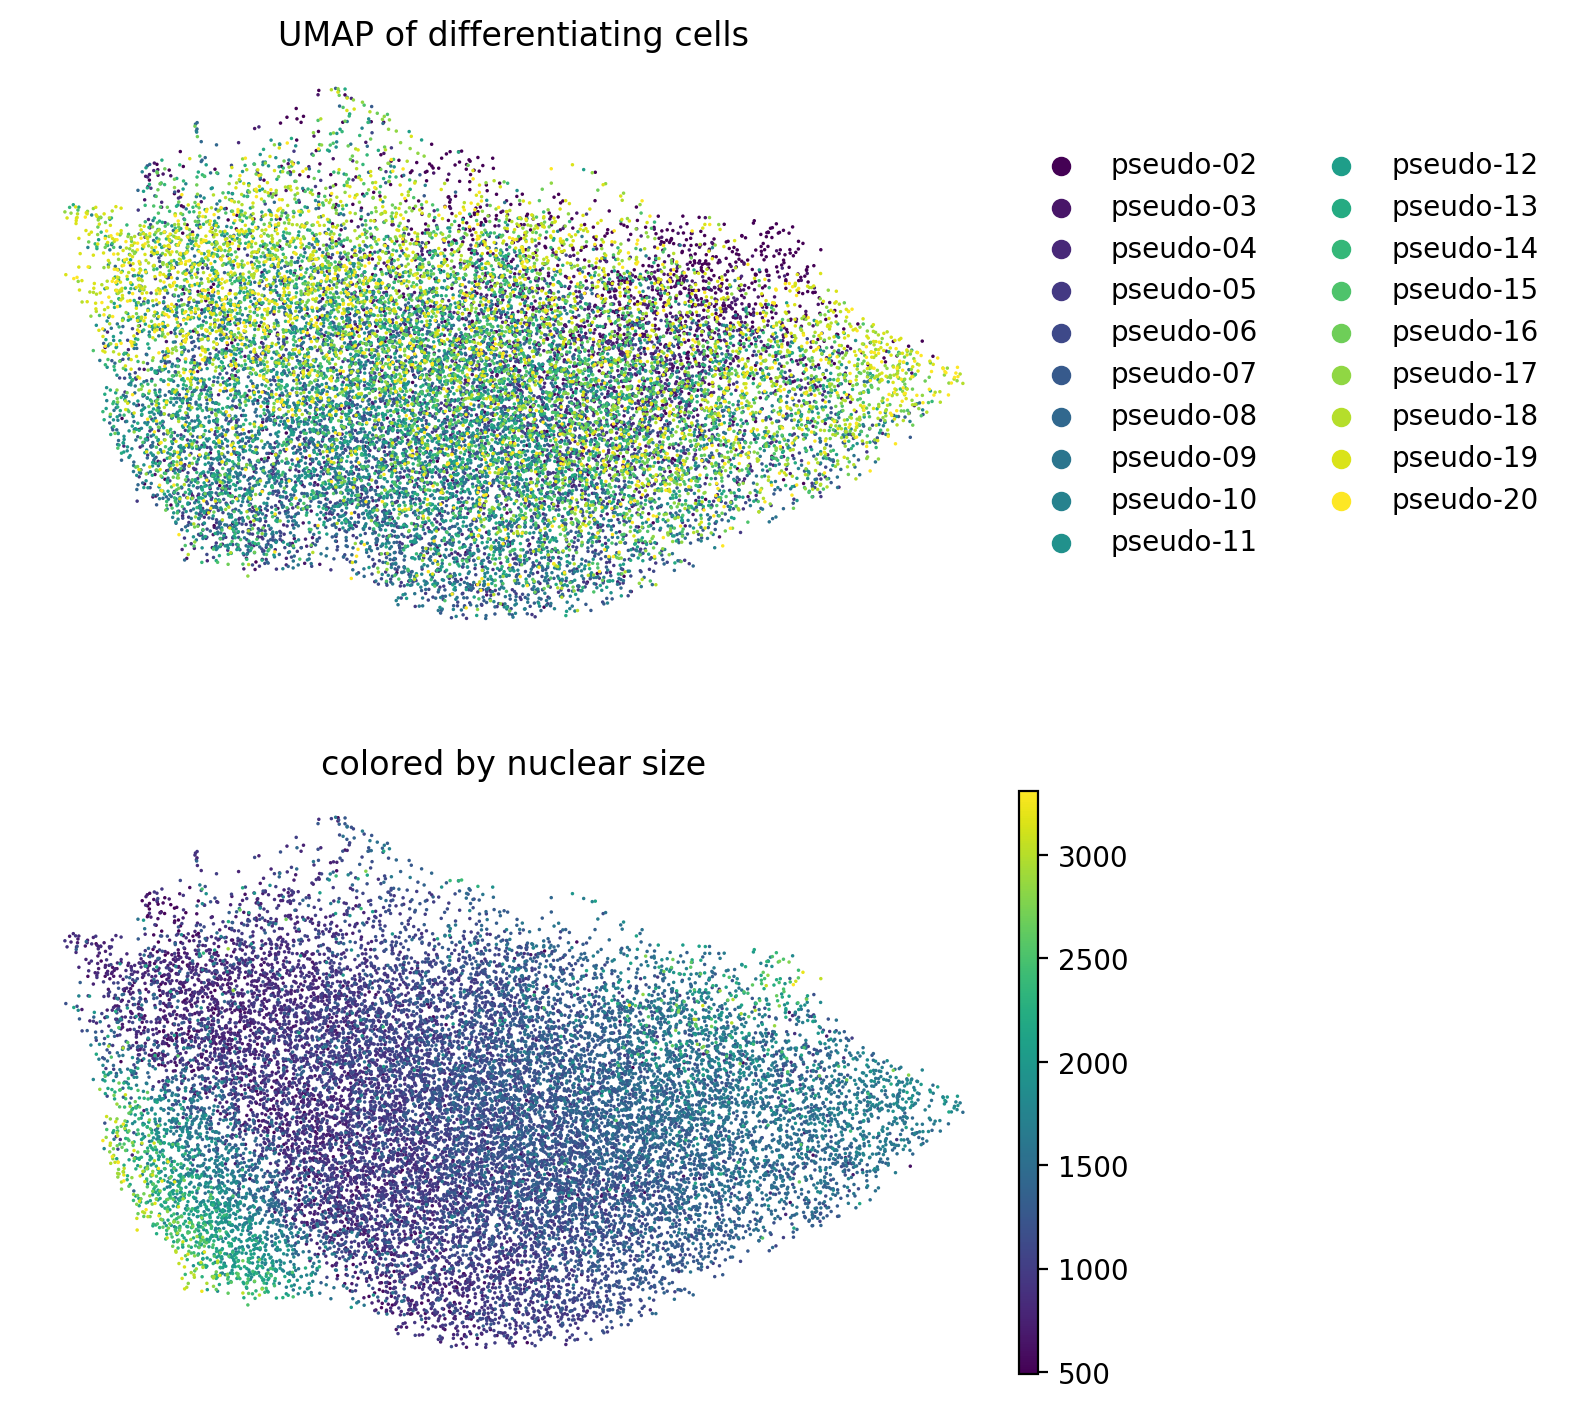

In [31]:
# Read in and prepare data
adata = sm.read(input_file, n_headers=1)
adata.raw = adata

# scale, compute PCA and UMAP, then plot UMAP
sm.pp.scale(adata)
sm.pp.pca(adata, n_comps=20)
sm.pp.neighbors(adata, n_neighbors=10)
sm.pp.umap(adata)
sm.dr.umap(
    adata,
    title=["UMAP of differentiating cells", "colored by nuclear size"],
    color=["Metadata_plate", "FilteredNuclei_AreaShape_Area"],
    palette="viridis",
    frameon=False,
    ncols=1,
)

This UMAP does not look too bad. We see decent intermixing of plates, suggesting that we do not have overly strong batch effects. However, we note that there are some protrusions from the UMAP that we were curious about. When coloured by nuclear size, there seem to be two clusters of particularly large sizes (here in the top right and far left). We know that, in the early time points, there are many progenitor cells that were large, so the top right cluster is not a concern. However, in later time points there should be fewer progenitors and hence not as many very large cells. We therefore chose a random subset of cells from the bottom left cluster and manually labeled them as real or segmentation issues (in CellProfiler). Most of these cells were indeed poorly segmented cells.

NOTE: protrusions from UMAPs by themselves are just a curiosity, because UMAPs can heavily distort the underlying data structure. In this example we were aware of segmentation errors, and so knew that we should look for outliers. In any case, it is easy enough to use CellProfiler to check for abnormalities in cells that look like outliers on the UMAP. **Never blindly remove cells because of UMAPs! Always confirm that these indeed are outliers you wish to remove!**

## Statistical analysis of outliers
In a next step, we wanted to understand whether there were any features that distinguish poorly segmented cells from "real" cells. For that, we labeled 93 mis-segmented cells from the bottom left cluster. Using this data, we can then find features that are significantly different between well- and poorly-segmented cells.

In [32]:
# Define paths for two files: one that contains all the cells marked as outlier cells
# and one containing data about manually labelled outlier cells
outlier_file = "./results/bhughes/02_pseudo_rough_umap_outlier_select_mdat.csv"
label_file = (
    "./results/bhughes/02_pseudo_rough_umap_outlier_select_mdat_annotated_certain.csv"
)

# load in files
df_outlier = pd.read_csv(outlier_file)
df_label = pd.read_csv(label_file)

# add information about outliers/labels to object
adata.obs["outlier"] = (
    adata.obs["Metadata_unique"].isin(df_outlier["Metadata_unique"]).astype("category")
)

adata.obs["outlier_labelled"] = (
    adata.obs["Metadata_unique"].isin(df_label["Metadata_unique"]).astype("category")
)

In [33]:
# Now, compute features that are significantly different between inliers and outliers
inl = adata[adata.obs["outlier"] == False]
outl = adata[adata.obs["outlier_labelled"] == True]

# perform KS tests for each feature
res = [ks_2samp(inl.X[:, i], outl.X[:, i])[1] for i in range(inl.shape[1])]
res = np.array(res)

# perform multiple testing correction
rej, res_adj = fdrcorrection(res, alpha=0.01)
print("Number of features sig. different between inliers and outliers:", np.sum(rej))

# extract which features were most significantly different
feat_sig_sorted = inl.var.index[np.argsort(res_adj)]
print(
    "\n".join(
        [
            i + " (qval: " + str(j) + ")"
            for i, j in zip(feat_sig_sorted[0:10], np.sort(res_adj)[0:10])
        ]
    )
)

Number of features sig. different between inliers and outliers: 472
FilteredNuclei_Intensity_IntegratedIntensity_W1 (qval: 5.419011454034275e-125)
FilteredNuclei_AreaShape_ConvexArea (qval: 9.441768590172148e-80)
FilteredNuclei_AreaShape_Area (qval: 2.794447693678047e-78)
FilteredNuclei_AreaShape_EquivalentDiameter (qval: 2.794447693678047e-78)
FilteredNuclei_AreaShape_Perimeter (qval: 7.412071362660284e-75)
FilteredNuclei_AreaShape_MaxFeretDiameter (qval: 3.772701267616497e-59)
FilteredNuclei_Intensity_IntegratedIntensityEdge_W1 (qval: 4.2255043900302064e-52)
FilteredNuclei_AreaShape_MajorAxisLength (qval: 7.665074110930113e-51)
FilteredNuclei_AreaShape_InertiaTensorEigenvalues_0 (qval: 7.665074110930113e-51)
FilteredNuclei_AreaShape_MinFeretDiameter (qval: 4.449162016262052e-45)


The above shows that the features most associated with outliers are related to nuclear size. This is in line with our expectations, given that segmentation errors will produce abnormally large nuclei. We could use this information to adapt our nuclear size thresholds in CellProfiler, or filter our cells based on nuclear size now. For example:

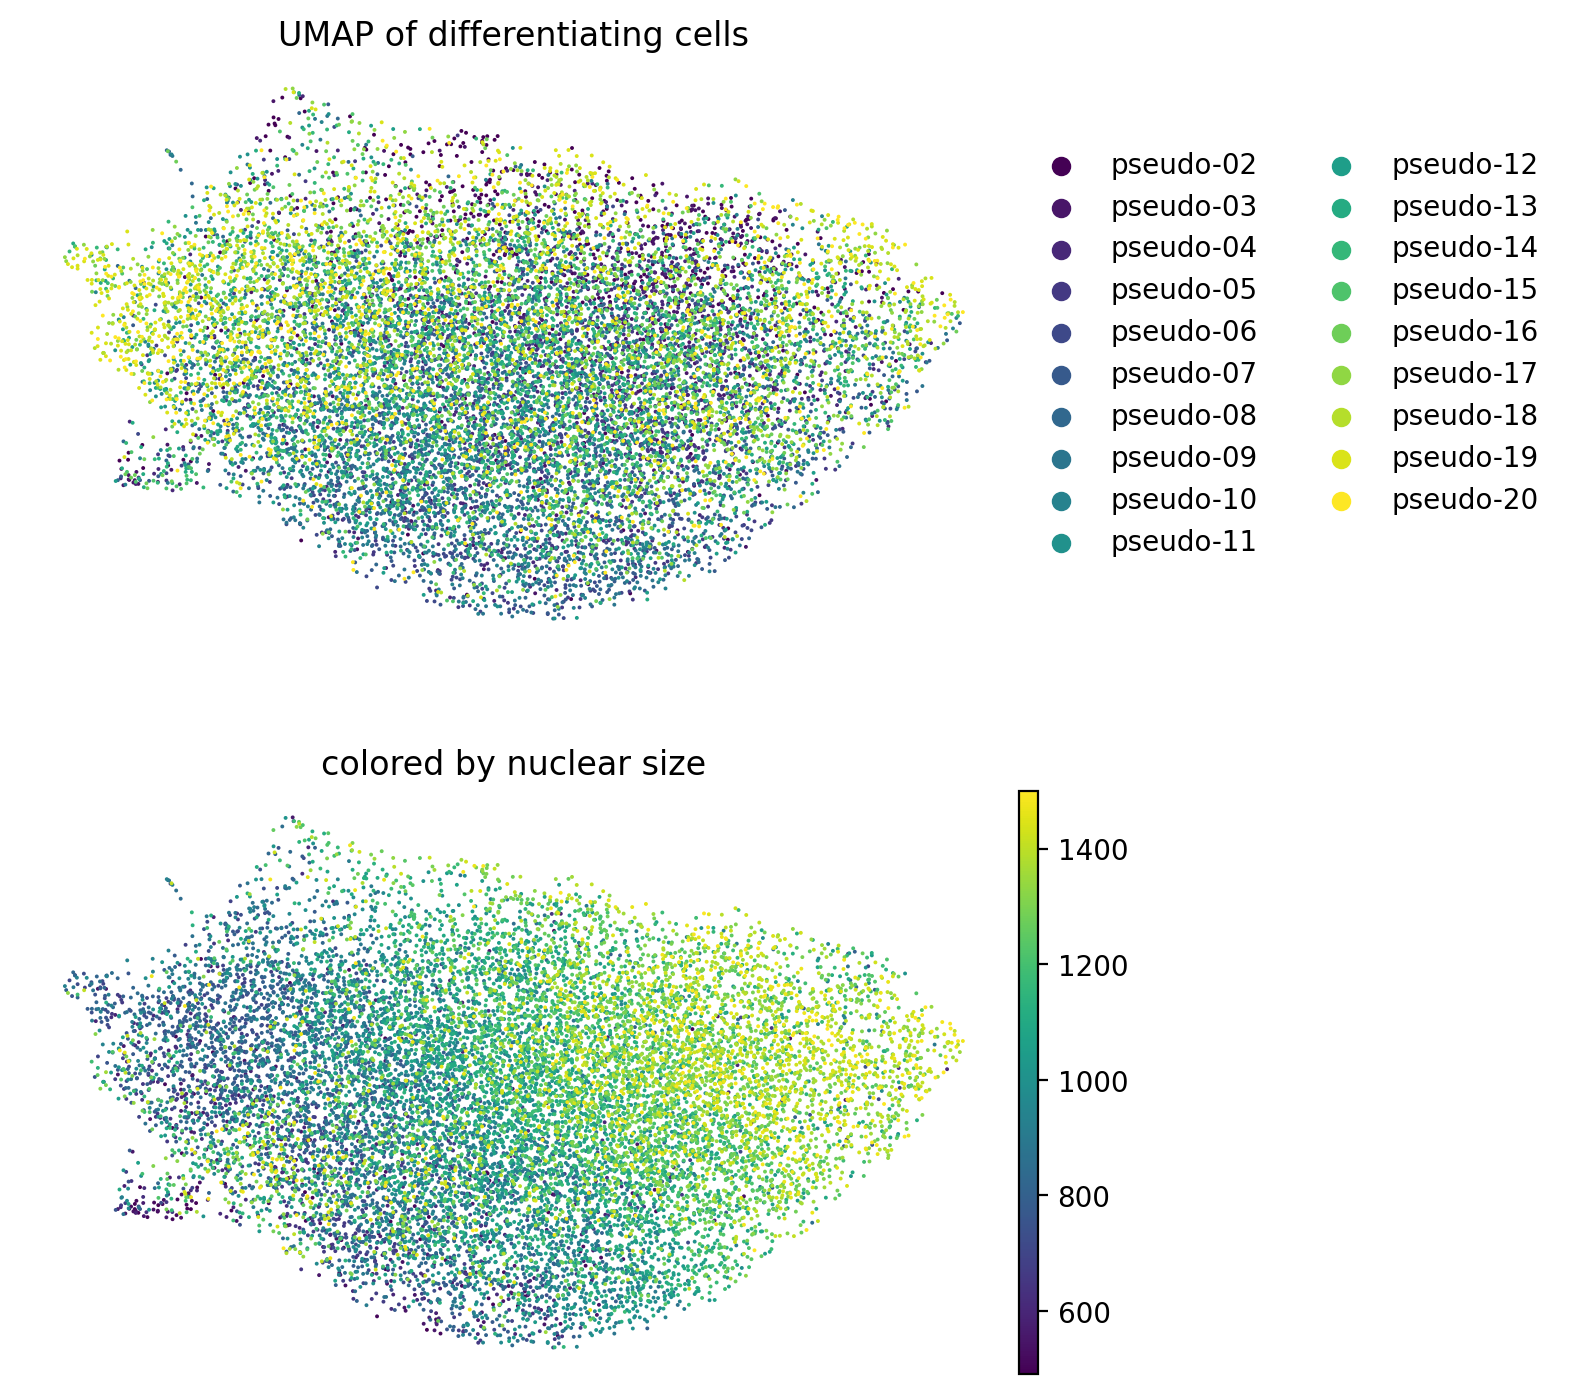

In [34]:
adata_ss = adata.raw.to_adata()
idx_largeCells = adata_ss[:, "FilteredNuclei_AreaShape_Area"].X > 1500
adata_ss = adata_ss[~idx_largeCells, :]
adata_ss.raw = adata_ss
sm.pp.scale(adata_ss)
sm.pp.pca(adata_ss, n_comps=20)
sm.pp.neighbors(adata_ss, n_neighbors=10)
sm.pp.umap(adata_ss)
sm.dr.umap(
    adata_ss,
    title=["UMAP of differentiating cells", "colored by nuclear size"],
    color=["Metadata_plate", "FilteredNuclei_AreaShape_Area"],
    palette="viridis",
    frameon=False,
    ncols=1,
)

## Machine-learning based removal of outliers
While we can see that we have now successfully removed the outlier group with large cells on the left, it also removed progenitor cells on the top right. This is concerning, since those cells represent real biology. To overcome this problem, we will take a machine-learning approach to finding outlier cells. In this way, we can incorporate knowledge of all cells to filter out only poorly segmented cells.

Because we knew that progenitor cells were an important, under-represented group, we want any algorithm to pay special attention not to remove them. But we cannot blindly assume which cells are progenitors based on UMAP coordinates. Therefore, we manually labelled large cells in the top right of the original UMAP to see if these are poorly segmented cells or indeed progenitors. This information was then used to build a 3-class classifier, that balances detecting outliers with retaining progenitors.

In [35]:
# add information about annotated progenitors
progenitor_file = "results/bhughes/02_pseudo_sc_sample_inlier_largeCells.csv"
df_progenitor = pd.read_csv(progenitor_file)

adata.obs["group"] = pd.Series(
    ["inlier"] * adata.shape[0], dtype=str, index=adata.obs.index
)

idx_prog = adata.obs["Metadata_unique"].isin(df_progenitor["Metadata_unique"])
adata.obs.loc[idx_prog, "group"] = "progenitor"
adata.obs.loc[adata.obs["outlier"] == True, "group"] = "outlier"

adata.obs["group"].value_counts(normalize=True)

inlier        0.905526
outlier       0.092263
progenitor    0.002211
Name: group, dtype: float64

We have very few labeled progenitors, some labeled outliers, and very many "normal" cells. This represents a problem for traditional ML models, as they rely on an even representation of classes. To overcome this problem, here we use a special version of the Random Forest model, which passes a balanced bootstrap of cells to each tree. More simply, it should be able to tell us which cells are outliers, progenitors, or "other".

Classifier accuracy: 95.43 %


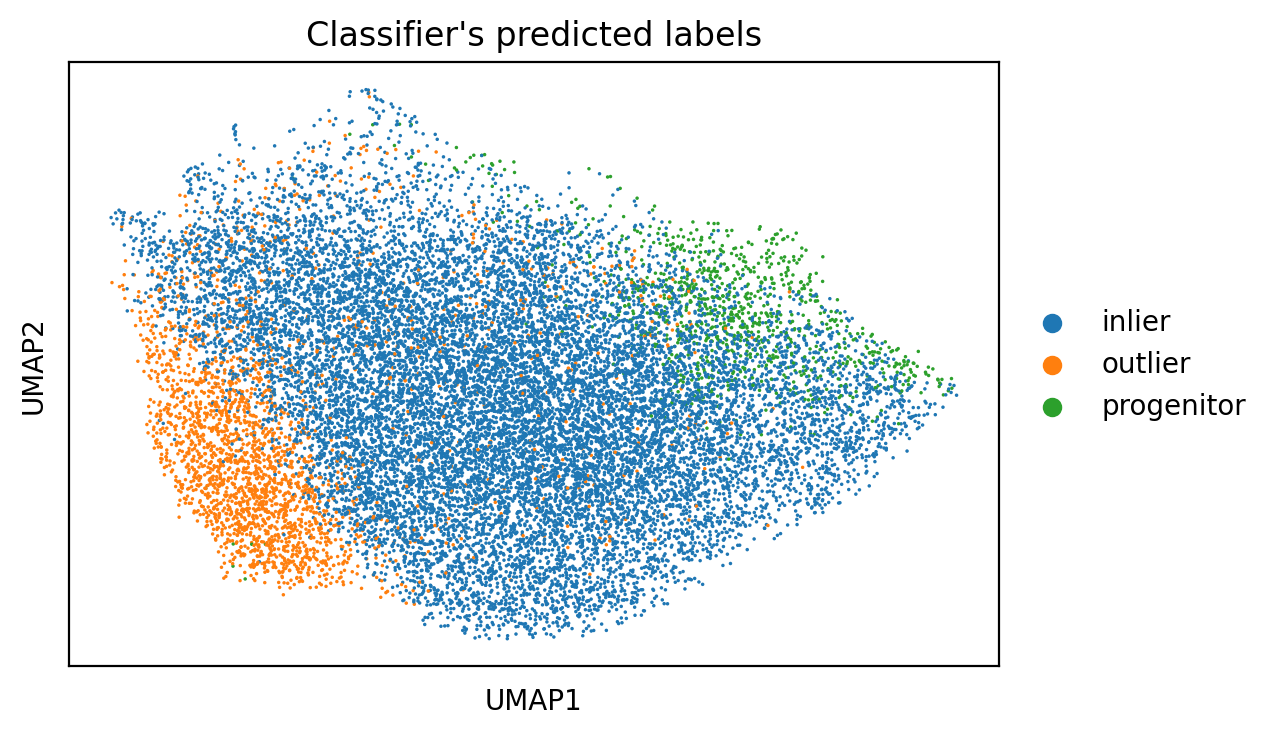

Top ten most important features:
FilteredNuclei_Intensity_IntegratedIntensity_W1
FilteredNuclei_AreaShape_EquivalentDiameter
FilteredNuclei_AreaShape_ConvexArea
Cytoplasm_Texture_SumAverage_W4_2_00_256
Cytoplasm_Texture_SumAverage_W4_2_03_256
FilteredNuclei_AreaShape_MedianRadius
FilteredNuclei_AreaShape_Area
Cytoplasm_Intensity_MedianIntensity_W4
Cytoplasm_Intensity_UpperQuartileIntensity_W4
FilteredNuclei_AreaShape_MinorAxisLength


In [36]:
from sklearn.preprocessing import LabelEncoder
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import cross_validate, cross_val_predict

enc = LabelEncoder()
X = adata.X
y = adata.obs["group"]
enc.fit(y)
y = enc.transform(y)

model = BalancedRandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X, y)
cv_results = cross_validate(model, X, y, scoring="balanced_accuracy", cv=5)
print("Classifier accuracy:", np.round(np.mean(cv_results["test_score"]) * 100, 2), "%")

y_pred = cross_val_predict(model, X, y, cv=5)
y_pred = enc.inverse_transform(y_pred)
adata.obs["pred_label"] = y_pred
sm.dr.umap(adata, color="pred_label", title="Classifier's predicted labels")

imp = model.feature_importances_
feat_sig_sorted = adata.var.index[np.argsort(-imp)]
print("Top ten most important features:\n" + "\n".join(feat_sig_sorted[0:10]))

Great! We now have a classifier that can detect outlier cells but does not classify progenitors as outliers. Let's use that to remove outliers and re-do our exploratory analysis.

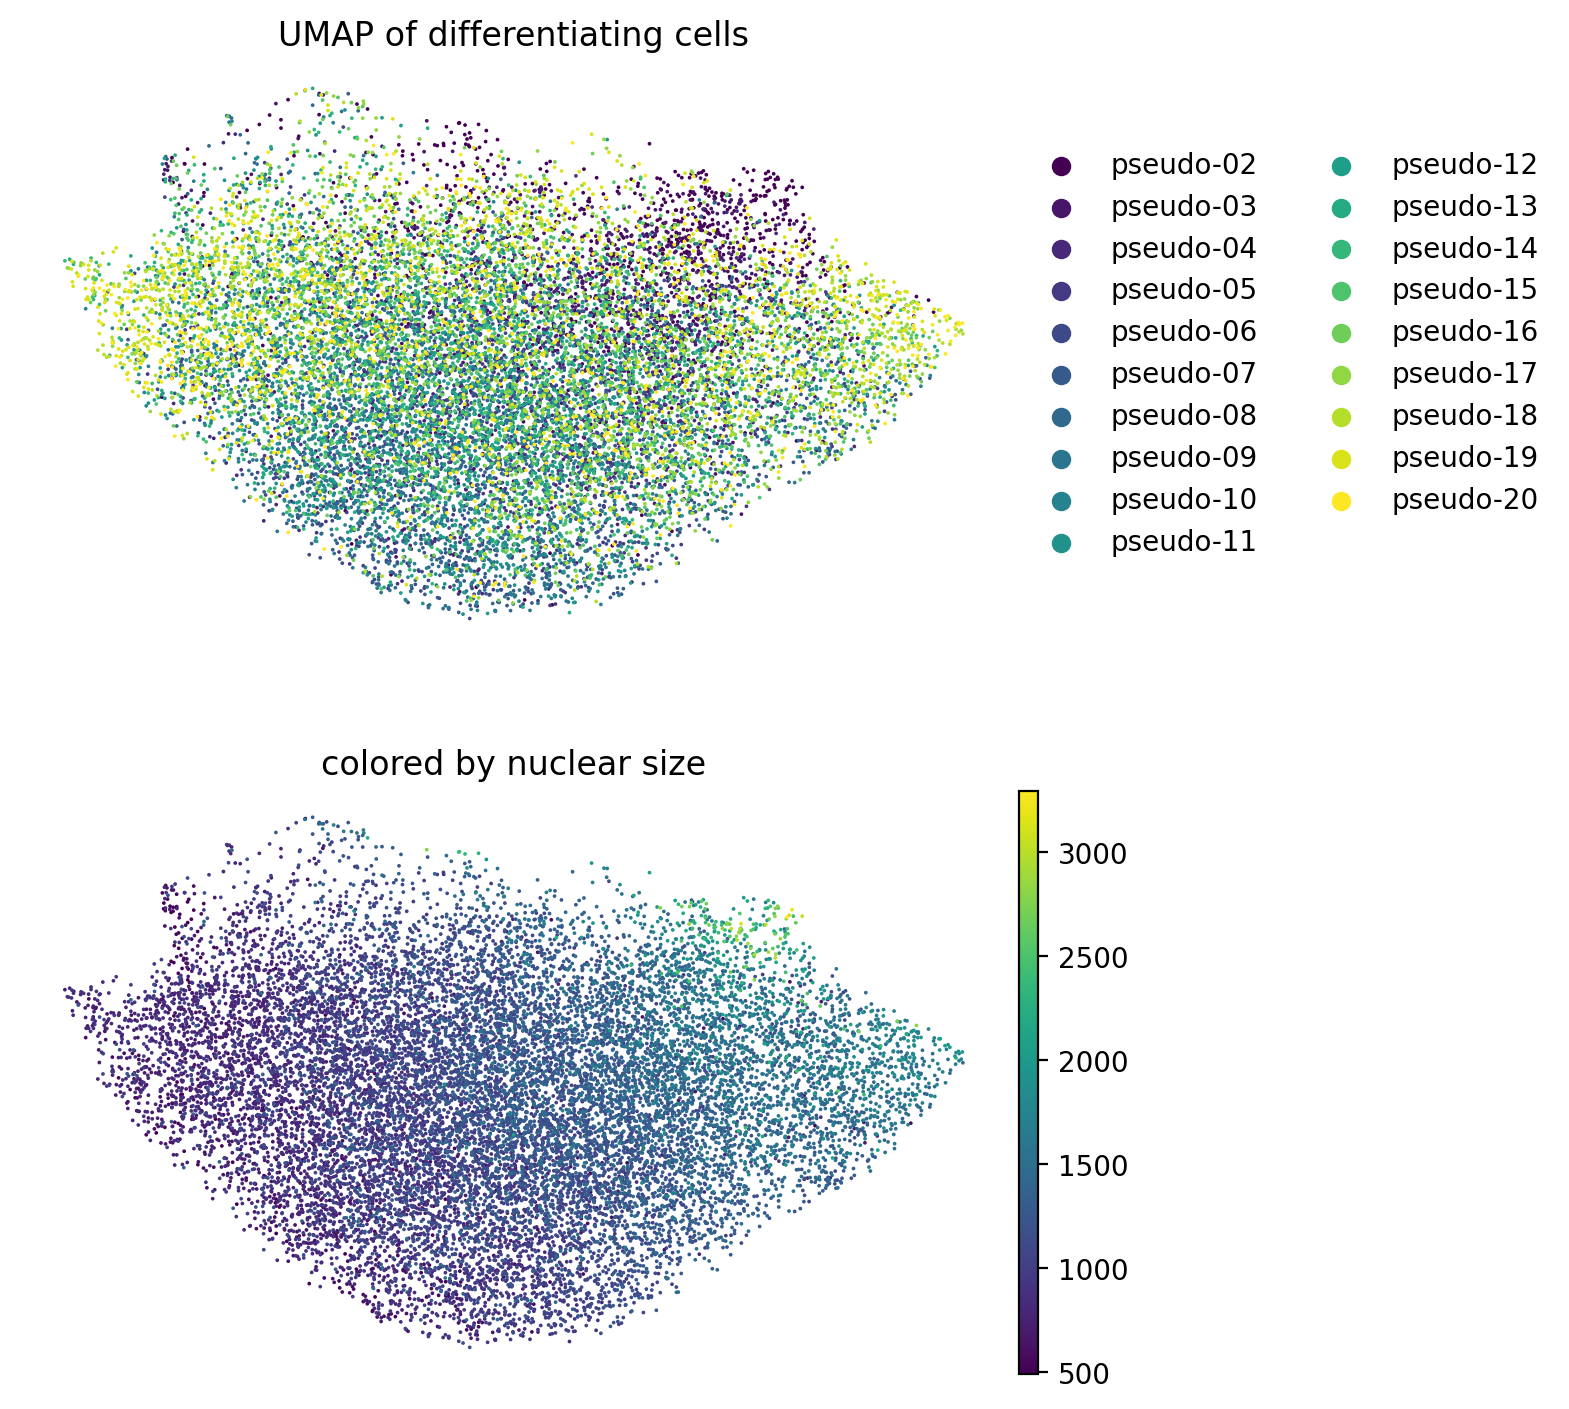

In [37]:
adata_ss = adata.raw.to_adata()
idx_keep = adata.obs["pred_label"] != "outlier"
adata_ss = adata_ss[idx_keep, :]
adata_ss.raw = adata_ss
sm.pp.scale(adata_ss)
sm.pp.pca(adata_ss, n_comps=20)
sm.pp.neighbors(adata_ss, n_neighbors=10)
sm.pp.umap(adata_ss)
sm.dr.umap(
    adata_ss,
    title=["UMAP of differentiating cells", "colored by nuclear size"],
    color=["Metadata_plate", "FilteredNuclei_AreaShape_Area"],
    palette="viridis",
    frameon=False,
    ncols=1,
)

In [44]:
adata_ss.obs.dtypes

FilteredNuclei_ObjectNumber                         int64
FilteredNuclei_AreaShape_BoundingBoxMaximum_X       int64
FilteredNuclei_AreaShape_BoundingBoxMaximum_Y       int64
FilteredNuclei_AreaShape_BoundingBoxMinimum_X       int64
FilteredNuclei_AreaShape_BoundingBoxMinimum_Y       int64
FilteredNuclei_AreaShape_Center_X                 float64
FilteredNuclei_AreaShape_Center_Y                 float64
FilteredNuclei_Location_Center_X                  float64
FilteredNuclei_Location_Center_Y                  float64
FilteredNuclei_Number_Object_Number                 int64
Cytoplasm_Number_Object_Number                      int64
Cells_AreaShape_BoundingBoxMaximum_X                int64
Cells_AreaShape_BoundingBoxMaximum_Y                int64
Cells_AreaShape_BoundingBoxMinimum_X                int64
Cells_AreaShape_BoundingBoxMinimum_Y                int64
Cells_AreaShape_Center_X                          float64
Cells_AreaShape_Center_Y                          float64
Cells_Location

In [46]:
# export data
adata_ss.obs.drop(["outlier","outlier_labelled"], inplace=True, axis=1)
adata_ss.write("results/bhughes/pseudo_sc_sample_filtered.h5ad")